In [14]:
from sciml.model.fno import FNO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU')
import os
from datetime import datetime

In [15]:
nb_xi = 2 # can be deduced from mu because it's len(mu.shape) - 1
p_1 = 30 # dimension of scheme for xi for all i
p_2 = 30 # dimension of scheme for xi for all i
p_3 = 30 # dimension of scheme for xi for all i
epochs = 5
index = 450
n_modes = p_1
n_layers = 4 # need to be low because there is a low difference between the with time
alpha = 0.5
best_loss = 0.00005
activation = 'relu'
kernel_initializer = 'he_normal'
device = "GPU"
n_epochs = epochs


In [16]:
# inputs are of the form [batch, p_1, p_1, nd_xi +1] for nb_xi=2 (+1 because of the mu=f(x))

first_network = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(p_1, p_1,)),  # [batch, p_1, p_1, 3]
    tf.keras.layers.Flatten(),  # [batch, p_1*p_1*3]
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(p_1 * p_1, activation='relu'),
    tf.keras.layers.Reshape((p_1, p_1,))  # [batch, p_1, p_1, p_2]
])

last_network = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(p_1, p_1,)),  # [batch, p_1, p_1, 3]
    tf.keras.layers.Flatten(),  # [batch, p_1*p_1*3]
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(p_1 * p_1 * (1), activation='linear'),
    tf.keras.layers.Reshape((p_1, p_1,))  # [batch, p_1, p_1, 3]
])


# first network graph:
# [batch, p_1, p_1, 3] -> [batch, p_1*p_1*3] -> [batch, 512] -> [batch, 256] -> [batch, p_1*p_1*p_2] -> [batch, p_1, p_1, p_2]
# last network graph:  
# [batch, p_1, p_1, 3] -> [batch, p_1*p_1*3] -> [batch, 256] -> [batch, 512] -> [batch, p_1*p_1*3] -> [batch, p_1, p_1, 3]

In [17]:
folder_path = "data/test_data/big_dataset_fno/heat2d/"

In [18]:
model = FNO(regular_params={"first_network": first_network, "last_network": last_network},fourier_params={"n_layers": n_layers, "dim_coords":2, "n_modes": n_modes, "activation": activation, "kernel_initializer": kernel_initializer}, hyper_params={"p_1": p_1, "p_2": p_2,'p_3':p_3,"device": device,"n_epochs":n_epochs,"index":index,"alpha":alpha,"folder_path":folder_path,"best_loss":best_loss})

2025-03-17 01:49:11,546 - sciml.model.fno.fno - INFO - Model initialized with 5 epochs, 32 batch size, 0.001 learning rate


In [19]:
os.makedirs('results/fnograph', exist_ok=True)

In [20]:
date = datetime.now().strftime("%Y%m%d_%H%M%S")

In [21]:
'''
tf.keras.utils.plot_model(model, 
                         to_file=f'results/fno/model_graph_{date}.png',
                         show_shapes=True, 
                         show_layer_names=True)
'''
# we create a txt file to save the model summary

"\ntf.keras.utils.plot_model(model, \n                         to_file=f'results/fno/model_graph_{date}.png',\n                         show_shapes=True, \n                         show_layer_names=True)\n"

print("Model visualization and summary saved to results/fno/")
+
mus, sol = model.get_data_partial(folder_path,alpha=alpha)

In [22]:
# print(mus.shape)
# print(sol.shape)

In [23]:
# import logging
tf.get_logger().setLevel('ERROR')
# Ajouter en haut du notebook pour désactiver tout le logging
# logging.getLogger().setLevel(logging.ERROR)  # Ne montrera que les erreurs graves

In [24]:
loss_history_train,loss_history_test = model.fit_partial(save_weights=True)

2025-03-17 01:49:19,913 - sciml.model.fno.fno - INFO - === Partial Training Started ===
2025-03-17 01:49:19,934 - sciml.model.fno.fno - INFO - Model Configuration:
2025-03-17 01:49:19,935 - sciml.model.fno.fno - INFO - Hyperparameters: {
  "p_1": 30,
  "p_2": 30,
  "p_3": 30,
  "device": "GPU",
  "n_epochs": 5,
  "index": 450,
  "alpha": 0.5,
  "folder_path": "data/test_data/big_dataset_fno/heat2d/",
  "best_loss": 5e-05
}
2025-03-17 01:49:19,936 - sciml.model.fno.fno - INFO - Fourier Parameters: {
  "n_layers": 4,
  "dim_coords": 2,
  "n_modes": 30,
  "activation": "relu",
  "kernel_initializer": "he_normal"
}
2025-03-17 01:49:19,938 - sciml.model.fno.fno - INFO - Data Shape - Inputs: (500, 30, 30), Solutions: (500, 30, 30)
2025-03-17 01:49:19,939 - sciml.model.fno.fno - INFO - Alpha (partial training fraction): 0.5
2025-03-17 01:49:19,940 - sciml.model.fno.fno - INFO - Device: GPU
2025-03-17 01:49:19.980771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

Failed to save weights


In [25]:
try:
    with open(f'results/fnograph/model_summary_{date}.txt', 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
except Exception as e:
    print(f"Error saving model summary: {e}")
    pass

Error saving model summary: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.


In [26]:
print(len(loss_history_train))
print(len(loss_history_test))

5
5


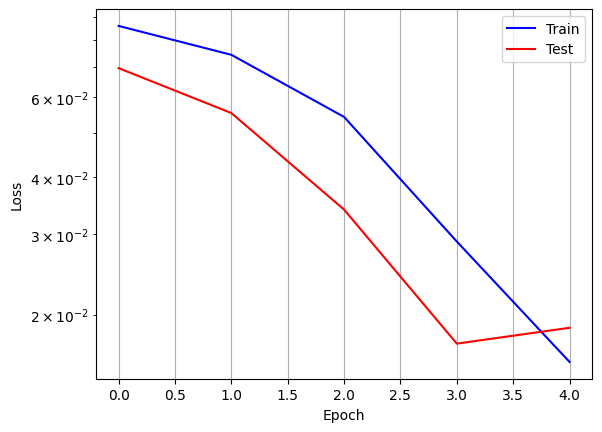

In [27]:
from datetime import datetime
plt.plot(loss_history_train,color='blue')
plt.plot(loss_history_test,color='red')
plt.legend(['Train','Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
date = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'results/loss_history_fno{date}.png')
plt.show()